In [ ]:
# Install JAX with the correct CUDA version for Colab
!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# Install PyMC and other needed packages
!pip install pymc arviz numpyro


Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [ ]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
import time

# Check available cores
n_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores available: {n_cores}")

Number of CPU cores available: 12


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Used to build meta_data surrounding models
df_all = pd.read_csv('/content/drive/MyDrive/NASA_data/modeling_data_no_sensor.csv')


<ipython-input-5-b9c5e7692411>:1: DtypeWarning: Columns (12,13,22,28,30,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv('/content/drive/MyDrive/NASA_data/modeling_data_no_sensor.csv')


In [ ]:
import os

model_path = '/content/drive/MyDrive/NASA_data/Models'

def load_trace(trace):
    try:
        trace = os.path.join(model_path, trace)
        print('Trace loaded successfully')
        trace_plot =  az.from_netcdf(trace)
        return trace_plot

    except FileNotFoundError:
        print("Error: tube_model_trace.nc not found. Make sure it's in the correct directory.")
    except Exception as e:
        print(f"An error occurred while loading the trace: {e}")

# MODEL DEFINITION

In [ ]:
with pm.Model() as tube_model_full_hier: # New model name
    # --- Data Prep --- (Same as before, ensuring _cats variables are created)
    tube_data = df_all[df_all['primary_measurement_type'] == 'tube'].copy()
    cluster_idx, cluster_cats = pd.factorize(tube_data['cluster_type_id'])
    season_idx, season_cats = pd.factorize(tube_data['season'])
    water_body_idx, water_body_cats = pd.factorize(tube_data['water_source_standardized'])
    n_sites = len(cluster_cats)
    n_seasons = len(season_cats)
    n_water_bodies = len(water_body_cats)
    coords = {
        "site": cluster_cats,
        "season": season_cats,
        "water_body": water_body_cats,
        "obs_id": np.arange(len(cluster_idx))
    }
    tube_model_full_hier.add_coords(coords)
    y = tube_data['pct_clear'].values
    y_adj = np.clip(y, 0.001, 0.999)
    y_logit = np.log(y_adj / (1 - y_adj))

    # --- Parameters ---
    # 1. Global Intercept (Level 3 Mean)
    mu_global = pm.Normal('mu_global', mu=0, sigma=10) # Grand mean (overall intercept)

    # --- Level 2 Standard Deviations (Variation BETWEEN groups) ---
    # sigma_site = pm.HalfNormal('sigma_site', sigma=10)    # How much site means vary around mu_global
    # sigma_season = pm.HalfNormal('sigma_season', sigma=2) # How much season means vary around mu_global
    # sigma_wb = pm.HalfNormal('sigma_wb', sigma=2)       # How much water body means vary around mu_global
    sigma_site = pm.HalfCauchy('sigma_site', beta=5)    # beta=5 might be okay if site variation can be large
    sigma_season = pm.HalfCauchy('sigma_season', beta=2.5) # beta=2.5 is a common "weakly informative" choice
    sigma_wb = pm.HalfCauchy('sigma_wb', beta=2.5)       # for scales of effects

    # --- Level 2 Raw Deviations (Non-centered parameters) ---
    # These are drawn from Normal(0, 1)
    site_effects_raw = pm.Normal('site_effects_raw', mu=0, sigma=1, dims="site")
    season_effects_raw = pm.Normal('season_effects_raw', mu=0, sigma=1, dims="season")
    wb_effects_raw = pm.Normal('wb_effects_raw', mu=0, sigma=1, dims="water_body")

    # --- Level 2 Actual Deviations (Deterministic) ---
    # These are the estimated deviations from mu_global for each group
    site_deviation = pm.Deterministic('site_deviation', site_effects_raw * sigma_site, dims="site")
    season_deviation = pm.Deterministic('season_deviation', season_effects_raw * sigma_season, dims="season")
    wb_deviation = pm.Deterministic('wb_deviation', wb_effects_raw * sigma_wb, dims="water_body")

    # 3. Interaction Effects (Season x Water Body)
    # Keep simple prior: deviation from purely additive main deviations
    # interaction_effects = pm.Normal('interaction_effects', mu=0, sigma=1, dims=("season", "water_body"))

    # 4. Observation-level variability (Level 1 variance)
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=1)

    # --- Linear predictor in logit space --- (Intercept + Deviations + Interaction)
    # The predicted mean for an observation is the global mean plus adjustments
    # for its specific site, season, water body, and the interaction term.
    mu_logit = (
        mu_global +                                         # Start with the grand mean
        site_deviation[cluster_idx] +                       # Add site-specific deviation
        season_deviation[season_idx] +                      # Add season-specific deviation
        wb_deviation[water_body_idx]                     # Add water body-specific deviation
        # interaction_effects[season_idx, water_body_idx]     # Add interaction adjustment
    )

    # --- Likelihood --- (Same as before)
    likelihood = pm.Normal('likelihood', mu=mu_logit, sigma=sigma_obs, observed=y_logit, dims="obs_id")

In [ ]:
with pm.Model() as tube_model_nested_wb:
    # --- Data Prep ---
    # Make sure df_all is defined and has required columns
    tube_data = df_all[df_all['primary_measurement_type'] == 'tube'].copy()
    # Filter out non-positive or invalid outcomes if necessary BEFORE factorizing
    # Assuming 'pct_clear' is the intended outcome for Logit-Normal
    y = tube_data['pct_clear'].values
    y_adj = np.clip(y, 0.001, 0.999)
    y_logit = np.log(y_adj / (1 - y_adj))

    # Factorize all levels
    cluster_idx, cluster_cats = pd.factorize(tube_data['cluster_type_id'])
    season_idx, season_cats = pd.factorize(tube_data['season'])
    water_body_idx, water_body_cats = pd.factorize(tube_data['water_source_standardized'])
    n_sites = len(cluster_cats)
    n_seasons = len(season_cats)
    n_water_bodies = len(water_body_cats)

    # --- Create Site -> Water Body Index Mapping ---
    print("Creating Site -> Water Body mapping...")
    site_to_wb_map_df = tube_data[['cluster_type_id', 'water_source_standardized']].drop_duplicates()
    cluster_id_to_idx = {name: i for i, name in enumerate(cluster_cats)}
    wb_name_to_idx = {name: i for i, name in enumerate(water_body_cats)}
    site_to_wb_index = np.full(n_sites, -1, dtype=int)
    for _, row in site_to_wb_map_df.iterrows():
        c_idx = cluster_id_to_idx.get(row['cluster_type_id'])
        wb_idx = wb_name_to_idx.get(row['water_source_standardized'])
        if c_idx is not None and wb_idx is not None:
            site_to_wb_index[c_idx] = wb_idx
    if np.any(site_to_wb_index == -1):
         raise ValueError("Could not map all sites to a water body index!")
    print("Mapping created.")

    coords = {
        "site": cluster_cats, "season": season_cats, "water_body": water_body_cats,
        "obs_id": np.arange(len(cluster_idx))
    }
    tube_model_nested_wb.add_coords(coords)

    # --- Parameters ---
    # Global Intercept (Level 3)
    mu_global = pm.Normal('mu_global', mu=0, sigma=10)

    # Water Body Level (Level 2)
    sigma_wb = pm.HalfCauchy('sigma_wb', beta=2.5) # Variation BETWEEN water body means
    wb_effects_raw = pm.Normal('wb_effects_raw', mu=0, sigma=1, dims="water_body")
    wb_effects = pm.Deterministic('wb_effects', mu_global + wb_effects_raw * sigma_wb, dims="water_body") # Mean for each WB

    # Site Level (Level 1 - Nested within Water Body)
    sigma_site = pm.HalfCauchy('sigma_site', beta=2.5) # Variation WITHIN water body types (between sites)
    site_effects_raw = pm.Normal('site_effects_raw', mu=0, sigma=1, dims="site")
    # The mean for site 's' is the effect of its water body: wb_effects[site_to_wb_index[s]]
    site_effects_per_site = pm.Deterministic('site_effects_per_site',
                                             wb_effects[site_to_wb_index] + site_effects_raw * sigma_site,
                                             dims="site")

    # Season Effects (Parallel - Fixed Prior)
    season_effects = pm.Normal('season_effects', mu=0, sigma=2, dims="season")

    # Observation Noise
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=1) # Using previous somewhat informative prior

    # --- Linear Predictor --- (Nested Site Effect + Parallel Season Effect)
    mu_logit = (
        site_effects_per_site[cluster_idx] + # This includes global, WB deviation, and site deviation
        season_effects[season_idx]
    )

    # --- Likelihood ---
    likelihood = pm.Normal('likelihood', mu=mu_logit, sigma=sigma_obs, observed=y_logit, dims="obs_id")

Creating Site -> Water Body mapping...
Mapping created.


In [ ]:
temp_first_obs = tube_data.loc[tube_data.groupby('cluster_type_id')['transparenciesMeasuredAt'].idxmin()] # Assuming datetime col exists
site_season_map_df = temp_first_obs[['cluster_type_id', 'season']].drop_duplicates()
cluster_id_to_idx = {name: i for i, name in enumerate(cluster_cats)} # From above
season_name_to_idx = {name: i for i, name in enumerate(season_cats)} # From above
site_to_season_index = np.full(n_sites, -1, dtype=int)
for _, row in site_season_map_df.iterrows():
     c_idx = cluster_id_to_idx.get(row['cluster_type_id'])
     s_idx = season_name_to_idx.get(row['season'])
     if c_idx is not None and s_idx is not None:
         site_to_season_index[c_idx] = s_idx
if np.any(site_to_season_index == -1):
      raise ValueError("Could not map all sites to a primary season index!")
print("Placeholder mapping created.")

with pm.Model() as tube_model_nested_season:
    # --- Coords --- (Same as Model A)
    tube_model_nested_season.add_coords(coords)
    # --- Observed Data --- (Same as Model A)
    y_logit = np.log(np.clip(tube_data['pct_clear'].values, 0.001, 0.999) / (1 - np.clip(tube_data['pct_clear'].values, 0.001, 0.999)))


    # --- Parameters ---
    # Global Intercept (Level 3)
    mu_global = pm.Normal('mu_global', mu=0, sigma=10)

    # Season Level (Level 2)
    sigma_season = pm.HalfCauchy('sigma_season', beta=2.5) # Variation BETWEEN season means
    season_effects_raw = pm.Normal('season_effects_raw', mu=0, sigma=1, dims="season")
    season_effects = pm.Deterministic('season_effects', mu_global + season_effects_raw * sigma_season, dims="season") # Mean for each Season

    # Site Level (Level 1 - Nested within Season)
    # NOTE: Naming sigma_site_within_season for clarity
    sigma_site_within_season = pm.HalfCauchy('sigma_site_within_season', beta=2.5) # Variation WITHIN seasons (between sites assigned to that season)
    # sigma_site_within_season = pm.HalfCauchy('sigma_site', beta=2.5) # Variation WITHIN seasons (between sites assigned to that season)
    site_effects_raw = pm.Normal('site_effects_raw', mu=0, sigma=1, dims="site")
    # The mean for site 's' is the effect of its assigned primary season: season_effects[site_to_season_index[s]]
    site_effects_per_site = pm.Deterministic('site_effects_per_site',
                                             season_effects[site_to_season_index] + site_effects_raw * sigma_site_within_season,
                                             dims="site")

    # Water Body Effects (Parallel - Fixed Prior)
    water_body_effects = pm.Normal('water_body_effects', mu=0, sigma=2, dims="water_body")

    # Observation Noise
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=1)

    # --- Linear Predictor --- (Nested Site Effect + Parallel WB Effect)
    mu_logit = (
        site_effects_per_site[cluster_idx] + # This includes global, season deviation, and site deviation
        water_body_effects[water_body_idx]
    )

    # --- Likelihood ---
    likelihood = pm.Normal('likelihood', mu=mu_logit, sigma=sigma_obs, observed=y_logit, dims="obs_id")

Placeholder mapping created.


In [ ]:
# SECCHI DISK MODEL

with pm.Model() as disk_model_nested_wb:
    # --- Data Prep ---
    # Make sure df_all is defined and has required columns
    disk_data = df_all[df_all['primary_measurement_type'] == 'disk'].copy()
    # Filter out non-positive or invalid outcomes if necessary BEFORE factorizing
    # Assuming 'pct_clear' is the intended outcome for Logit-Normal
    y = disk_data['transparenciesTransparencyDiskImageDisappearanceM'].values
    y_adj = np.clip(y, 0.001, 0.999)
    y_logit = np.log(y_adj / (1 - y_adj))

    # Factorize all levels
    cluster_idx, cluster_cats = pd.factorize(disk_data['cluster_type_id'])
    season_idx, season_cats = pd.factorize(disk_data['season'])
    water_body_idx, water_body_cats = pd.factorize(disk_data['water_source_standardized'])
    n_sites = len(cluster_cats)
    n_seasons = len(season_cats)
    n_water_bodies = len(water_body_cats)

    # --- Create Site -> Water Body Index Mapping ---
    print("Creating Site -> Water Body mapping...")
    site_to_wb_map_df = disk_data[['cluster_type_id', 'water_source_standardized']].drop_duplicates()
    cluster_id_to_idx = {name: i for i, name in enumerate(cluster_cats)}
    wb_name_to_idx = {name: i for i, name in enumerate(water_body_cats)}
    site_to_wb_index = np.full(n_sites, -1, dtype=int)
    for _, row in site_to_wb_map_df.iterrows():
        c_idx = cluster_id_to_idx.get(row['cluster_type_id'])
        wb_idx = wb_name_to_idx.get(row['water_source_standardized'])
        if c_idx is not None and wb_idx is not None:
            site_to_wb_index[c_idx] = wb_idx
    if np.any(site_to_wb_index == -1):
         raise ValueError("Could not map all sites to a water body index!")
    print("Mapping created.")

    coords = {
        "site": cluster_cats, "season": season_cats, "water_body": water_body_cats,
        "obs_id": np.arange(len(cluster_idx))
    }
    disk_model_nested_wb.add_coords(coords)

    # --- Parameters ---
    # Global Intercept (Level 3)
    mu_global = pm.Normal('mu_global', mu=0, sigma=10)

    # Water Body Level (Level 2)
    sigma_wb = pm.HalfCauchy('sigma_wb', beta=2.5) # Variation BETWEEN water body means
    wb_effects_raw = pm.Normal('wb_effects_raw', mu=0, sigma=1, dims="water_body")
    wb_effects = pm.Deterministic('wb_effects', mu_global + wb_effects_raw * sigma_wb, dims="water_body") # Mean for each WB

    # Site Level (Level 1 - Nested within Water Body)
    sigma_site = pm.HalfCauchy('sigma_site', beta=2.5) # Variation WITHIN water body types (between sites)
    site_effects_raw = pm.Normal('site_effects_raw', mu=0, sigma=1, dims="site")
    # The mean for site 's' is the effect of its water body: wb_effects[site_to_wb_index[s]]
    site_effects_per_site = pm.Deterministic('site_effects_per_site',
                                             wb_effects[site_to_wb_index] + site_effects_raw * sigma_site,
                                             dims="site")

    # Season Effects (Parallel - Fixed Prior)
    season_effects = pm.Normal('season_effects', mu=0, sigma=2, dims="season")

    # Observation Noise
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=1) # Using previous somewhat informative prior

    # --- Linear Predictor --- (Nested Site Effect + Parallel Season Effect)
    mu_logit = (
        site_effects_per_site[cluster_idx] + # This includes global, WB deviation, and site deviation
        season_effects[season_idx]
    )

    # --- Likelihood ---
    likelihood = pm.Normal('likelihood', mu=mu_logit, sigma=sigma_obs, observed=y_logit, dims="obs_id")

Creating Site -> Water Body mapping...
Mapping created.


# ANALYSIS

In [ ]:
# Trace object used to combine trace + model definitions
class trace_obj:
  def __init__(self, name, trace_path):
    self.trace_path = trace_path
    self.trace = load_trace(trace_path)
    self.name = name

  def load_model(self,model):
    self.model = model

  def add_ppc(self):
    with self.model:
      ppc = pm.sample_posterior_predictive(self.trace, var_names = ['likelihood'], random_seed=42)
    self.trace.add_groups({'posterior_predictive':ppc.posterior_predictive})

In [ ]:
# Secchi Disk Model (This one did not sample/converge well)
disk_model = trace_obj(trace_path ='disk_model_trace_nested_wb.nc', name = 'Disk Model')
disk_model.load_model(disk_model_nested_wb)

Trace loaded successfully


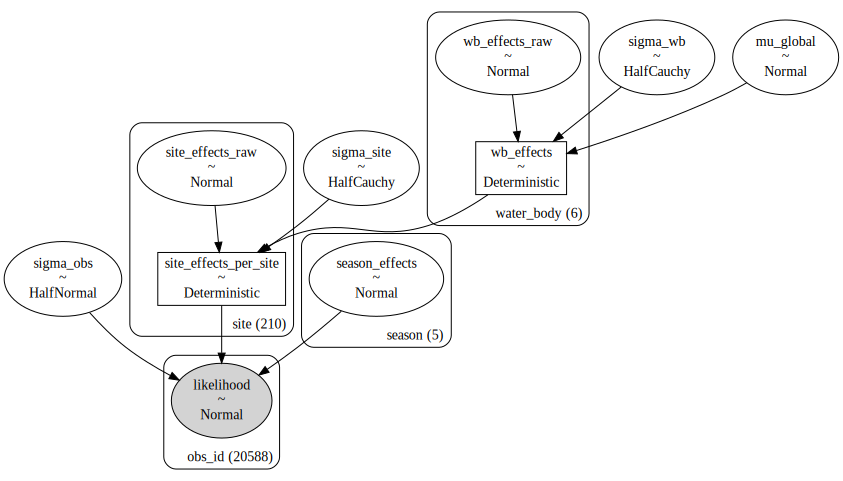

In [ ]:
pm.model_to_graphviz(disk_model.model)

In [ ]:
disk_model.add_ppc()

Output()

In [ ]:
model_hier = trace_obj(trace_path ='tube_model_trace_full_hier_pct_clear.nc', name = 'Parallel Model')

Trace loaded successfully


In [ ]:
model_hier.load_model(tube_model_full_hier)

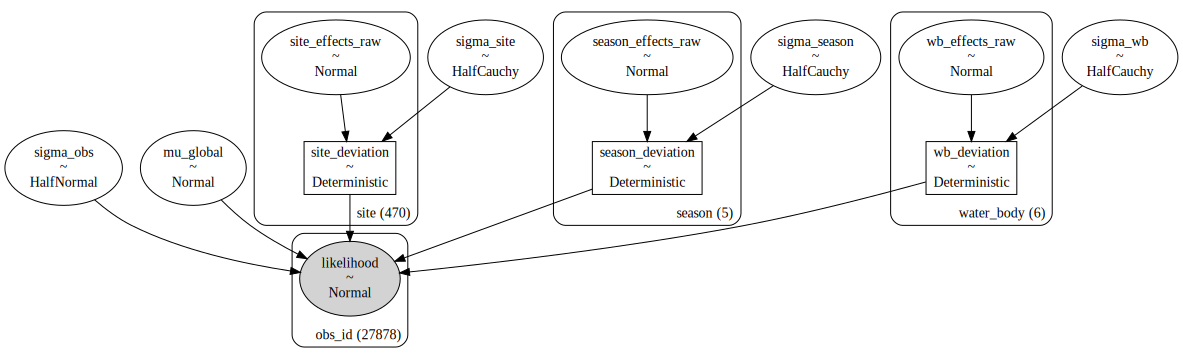

In [ ]:
pm.model_to_graphviz(model_hier.model)

In [ ]:
model_hier.add_ppc()

Output()

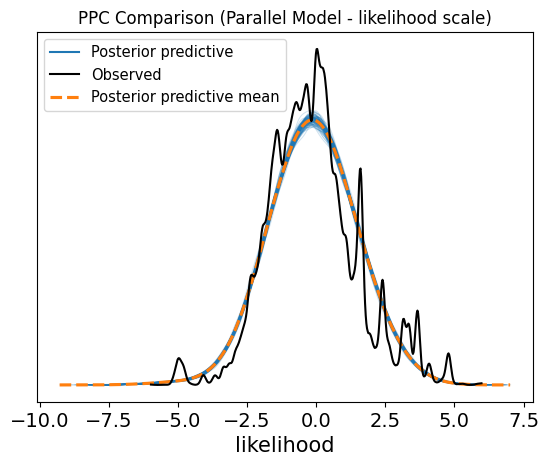

In [ ]:
az.plot_ppc(model_hier.trace, var_names=['likelihood'], kind='kde', num_pp_samples=100)
plt.title(f"PPC Comparison ({model_hier.name} - {'likelihood'} scale)")
plt.show()

In [ ]:
model_a = trace_obj(trace_path ='trace_nested_wb.nc', name = 'Water_Body_Nested')
model_a.load_model(tube_model_nested_wb)

Trace loaded successfully


In [ ]:
model_a.add_ppc()

Output()

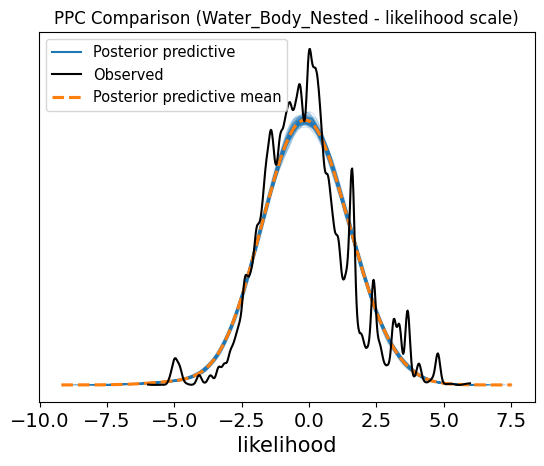

In [ ]:
az.plot_ppc(model_a.trace, var_names=['likelihood'], kind='kde', num_pp_samples=100)
plt.title(f"PPC Comparison ({model_a.name} - {'likelihood'} scale)")
plt.show()

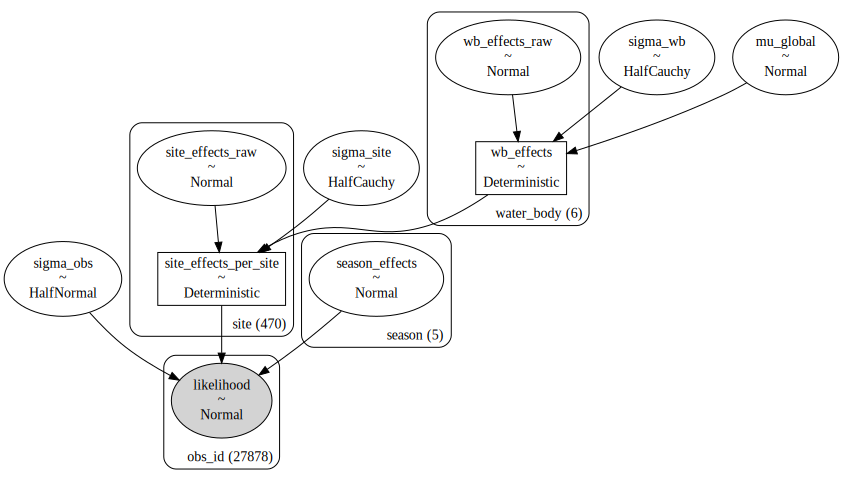

In [ ]:
pm.model_to_graphviz(model_a.model)

In [ ]:
model_b = trace_obj(trace_path = 'trace_nested_season.nc', name = 'Season_Nested')
model_b.load_model(tube_model_nested_season)

Trace loaded successfully


In [ ]:
model_b.add_ppc()

Output()

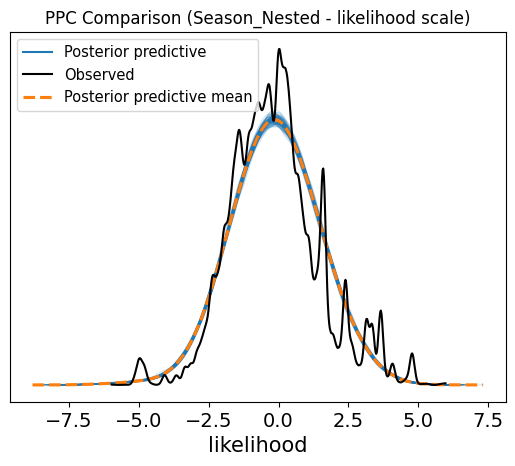

In [ ]:
az.plot_ppc(model_b.trace, var_names=['likelihood'], kind='kde', num_pp_samples=100)
plt.title(f"PPC Comparison ({model_b.name} - {'likelihood'} scale)")
plt.show()

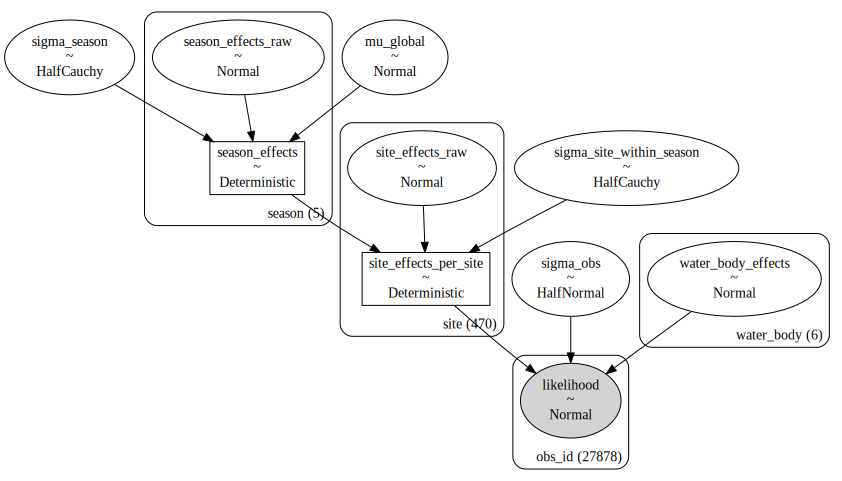

In [ ]:
pm.model_to_graphviz(model_b.model)

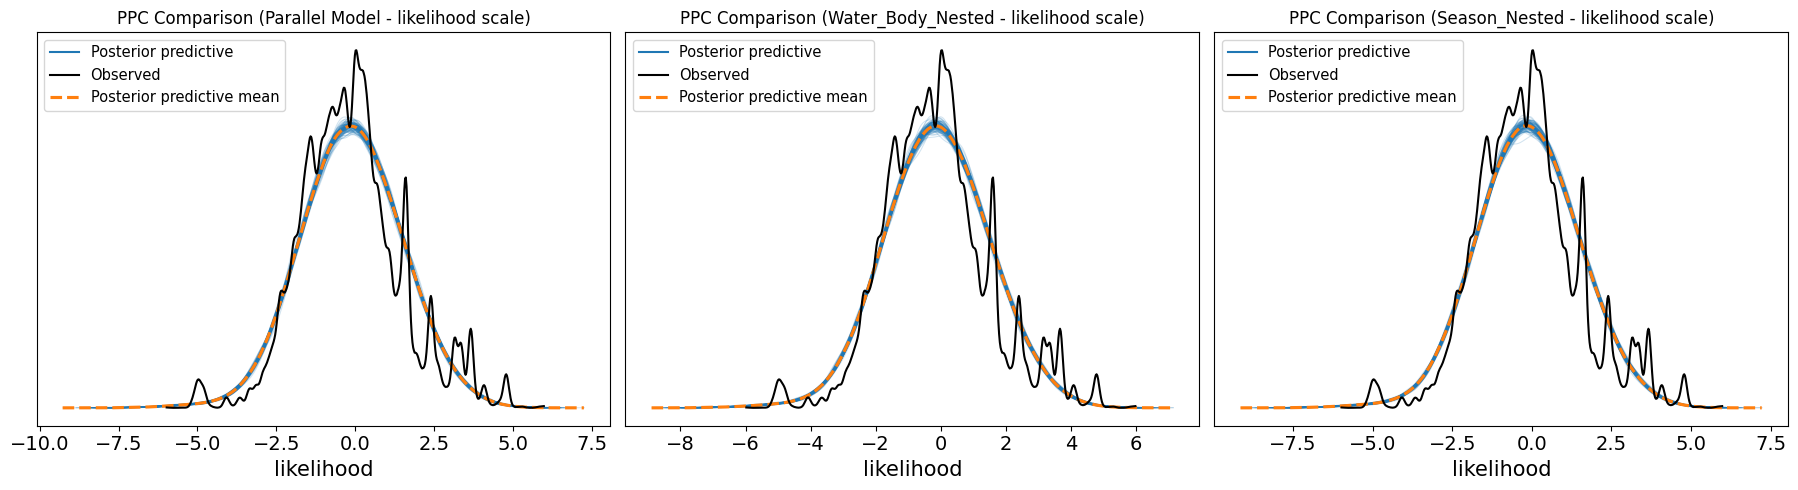

In [ ]:
# ALL PPC plots:

# Create a figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot in the first subplot
az.plot_ppc(model_hier.trace, var_names=['likelihood'], kind='kde',
            num_pp_samples=100, ax=axes[0])
axes[0].set_title(f"PPC Comparison ({model_hier.name} - {'likelihood'} scale)")

# Plot in the second subplot
az.plot_ppc(model_a.trace, var_names=['likelihood'], kind='kde',
            num_pp_samples=100, ax=axes[1])
axes[1].set_title(f"PPC Comparison ({model_a.name} - {'likelihood'} scale)")

# Plot in the third subplot
az.plot_ppc(model_b.trace, var_names=['likelihood'], kind='kde',
            num_pp_samples=100, ax=axes[2])
axes[2].set_title(f"PPC Comparison ({model_b.name} - {'likelihood'} scale)")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

In [ ]:
# ANALYSIS OF RESULTS

array([<Axes: title={'center': '99.0% HDI'}>], dtype=object)

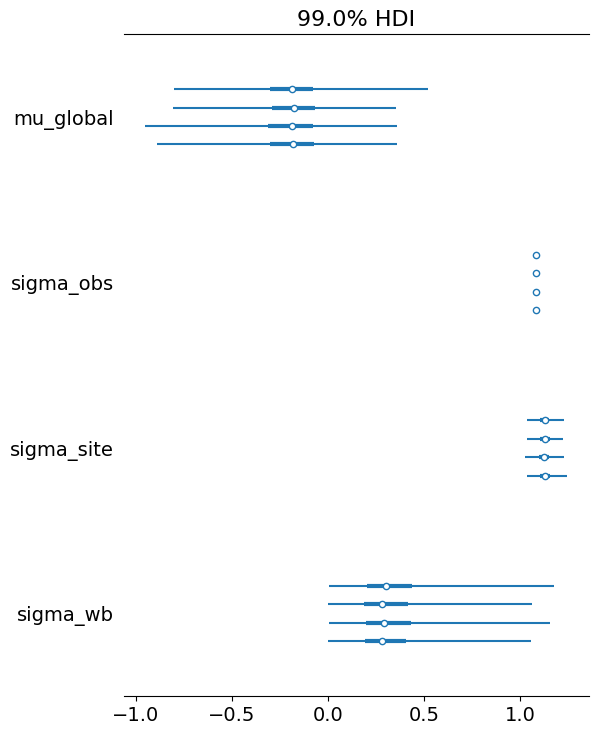

In [ ]:
var_names = ['mu_global','sigma_obs','sigma_site','sigma_wb']
az.plot_forest(model_hier.trace, var_names=var_names, hdi_prob=0.99)

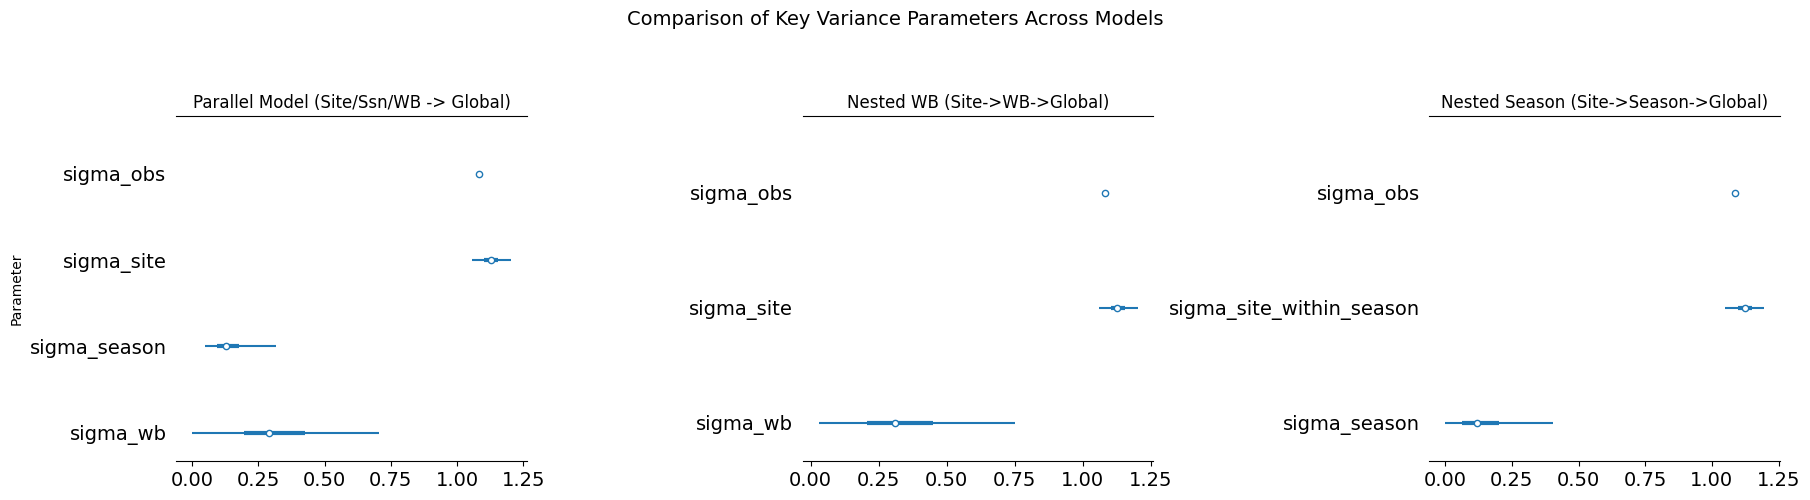

In [ ]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# --- Prerequisites ---
# Assume model_hier, model_a, model_b are your trace_obj instances
# and model_hier.trace, model_a.trace, model_b.trace hold the loaded InferenceData objects.
# Make sure these traces have passed all diagnostic checks.

# Example: Ensure traces are assigned (replace with your actual trace variables)
try:
    trace_hier = model_hier.trace # From 'Parallel Hierarchies' model
    trace_a = model_a.trace       # From 'Nested Water Body' model
    trace_b = model_b.trace       # From 'Nested Season' model
except NameError:
    print("ERROR: One or more model trace objects (trace_hier, trace_a, trace_b) are not defined.")
    trace_hier, trace_a, trace_b = (None, None, None) # Allow code to run

# --- Create Figure for Comparison ---
# Changed to 3 subplots and sharey=False
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False) # sharey=False allows independent Y-axes
fig.suptitle("Comparison of Key Variance Parameters Across Models", fontsize=14, y=1.02)

# Helper function (same as before)
def plot_parameters_for_model(trace, var_names_list, ax, title):
    """Helper to plot forest plot for existing variables or show error on axis."""
    if trace:
        # Filter var_names_list to only those present in the trace
        posterior_vars = list(trace.posterior.data_vars) if hasattr(trace, 'posterior') else []
        vars_to_plot_for_this_model = [v for v in var_names_list if v in posterior_vars]

        if vars_to_plot_for_this_model:
            try:
                az.plot_forest(trace,
                               var_names=vars_to_plot_for_this_model, # Use the filtered list
                               combined=True,
                               hdi_prob=0.94,
                               ax=ax)
                ax.set_title(title)
            except Exception as e:
                ax.set_title(f"{title}\nPlot Error")
                print(f"Error plotting {title}: {e}")
                ax.text(0.5, 0.5, 'Plotting Error', ha='center', va='center', transform=ax.transAxes)
                ax.set_yticks([]); ax.set_xticks([])
        else:
             ax.set_title(f"{title}\n(Selected vars not in trace)")
             ax.text(0.5, 0.5, 'Vars not in trace', ha='center', va='center', transform=ax.transAxes)
             ax.set_yticks([]); ax.set_xticks([])
    else:
        ax.set_title(f"{title}\nTrace not loaded")
        ax.text(0.5, 0.5, 'Trace Missing', ha='center', va='center', transform=ax.transAxes)
        ax.set_yticks([]); ax.set_xticks([])
        print(f"Skipping plot for {title}: Trace not loaded.")

# --- Define specific vars for each model ---
# Make sure these names EXACTLY match your model definitions
vars_hier = ['sigma_obs', 'sigma_site', 'sigma_season', 'sigma_wb']
vars_a    = ['sigma_obs', 'sigma_site', 'sigma_wb'] # Nested WB: has sigma_site & sigma_wb
vars_b    = ['sigma_obs', 'sigma_site_within_season', 'sigma_season'] # Nested Season: has sigma_site_within_season & sigma_season

# --- Plot for Model Hier (Parallel Hierarchies) ---
plot_parameters_for_model(trace_hier, vars_hier, axes[0], "Parallel Model (Site/Ssn/WB -> Global)")

# --- Plot for Model A (Nested WB) ---
plot_parameters_for_model(trace_a, vars_a, axes[1], "Nested WB (Site->WB->Global)")

# --- Plot for Model B (Nested Season) ---
plot_parameters_for_model(trace_b, vars_b, axes[2], "Nested Season (Site->Season->Global)")

# --- Finalize Plot ---
if len(axes) > 0 :
    axes[0].set_ylabel("Parameter") # Only label first y-axis if desired
# You might want to manually adjust y-limits slightly if scales are very different,
# but forest plot usually handles this okay. Example:
# axes[0].set_ylim(-0.5, len(vars_hier) - 0.5) # Adjust based on number of vars plotted
# axes[1].set_ylim(-0.5, len(vars_a) - 0.5)
# axes[2].set_ylim(-0.5, len(vars_b) - 0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
plt.show()

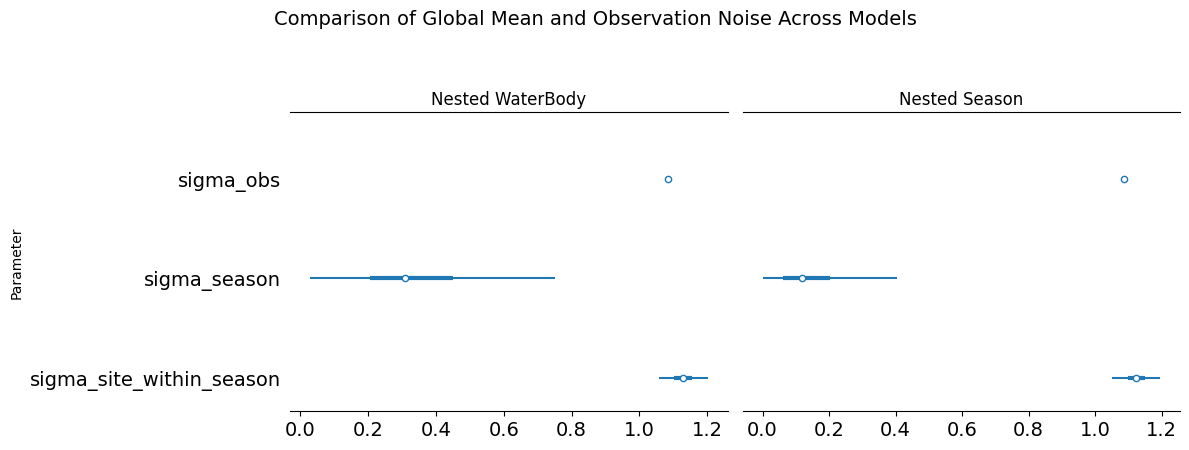

In [ ]:
import pymc as pm # May not be strictly needed here, but good practice
import arviz as az
import numpy as np
import pandas as pd # May be needed if reloading data/models
import matplotlib.pyplot as plt
import time

# --- Prerequisites ---
# Assume you have loaded your three successful traces from the models:
# trace_hier: From the 'Parallel Hierarchies' model (Site/Season/WB -> Global)
# trace_a: From the 'Nested Water Body' model (Site -> WB -> Global + Season)
# trace_b: From the 'Nested Season' model (Site -> Season -> Global + WB)
# Ensure these traces are loaded and have passed diagnostic checks.

# Example using placeholder objects if you used the class:
trace_hier = model_hier.trace
trace_a = model_a.trace
trace_b = model_b.trace

# --- Variables to Plot ---
vars_to_plot = ['sigma_obs','sigma_wb','sigma_site']

# --- Create Figure for Comparison ---
# Create 3 subplots in 1 row
# Keep sharey=True so 'mu_global' and 'sigma_obs' labels align horizontally
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharey=True)
fig.suptitle("Comparison of Global Mean and Observation Noise Across Models", fontsize=14, y=1.02)

# Helper function to plot or handle errors gracefully
def plot_or_skip(trace, var_names, ax, title):
    """Helper to plot forest plot or show error on axis."""
    if trace:
        try:
            az.plot_forest(trace,
                           var_names=var_names,
                           # NO 'coords' argument needed for scalar parameters
                           combined=True,
                           hdi_prob=0.94,
                           ax=ax)
            ax.set_title(title)
            # Optional: Adjust x-limits if scales differ wildly, though forest plot handles this somewhat
            # ax.set_xlim(desired_min, desired_max)
        except Exception as e:
            ax.set_title(f"{title}\nPlot Error")
            print(f"Error plotting {title}: {e}")
            # Add dummy text to axis if plot fails
            ax.text(0.5, 0.5, 'Plotting Error', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_yticks([]) # Clear y-ticks on error
            ax.set_xticks([]) # Clear x-ticks on error
    else:
        ax.set_title(f"{title}\nTrace not loaded")
        ax.text(0.5, 0.5, 'Trace Missing', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_yticks([])
        ax.set_xticks([])
        print(f"Skipping plot for {title}: Trace not loaded.")

# --- Plot for Model A (Nested WB) ---
plot_or_skip(trace_a,  vars_to_plot, axes[0], "Nested WaterBody")

# --- Plot for Model Hier ---
# plot_or_skip(trace_hier, vars_to_plot, axes[0], "Parallel Model")



# --- Plot for Model B (Nested Season) ---
plot_or_skip(trace_b, ['sigma_obs','sigma_season','sigma_site_within_season'], axes[1], "Nested Season")

# --- Finalize Plot ---
# Add common Y label if needed (parameter names should appear automatically)
axes[0].set_ylabel("Parameter")
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
plt.show()

In [ ]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# --- Prerequisites ---
# Assume you have loaded your three successful traces:
# trace_hier, trace_a, trace_b
# Ensure they have good diagnostics.
# Assume the site coordinate labels are stored correctly in each trace.

# --- Choose Sites to Compare ---
# Select a few representative site labels (must be present in cluster_cats)
# Replace these with actual site labels from your data!
sites_to_compare = var_sites # EXAMPLE LABELS

trace_hier = model_hier.trace
trace_a = model_a.trace
trace_b = model_b.trace
# Check if labels exist in coords (use one trace, assuming coords are the same)
if trace_a: # Check on trace_a for example
    available_sites = trace_a.posterior.coords['site'].values
    valid_sites_to_compare = [s for s in sites_to_compare if s in available_sites]
    if len(valid_sites_to_compare) != len(sites_to_compare):
        print("Warning: Some requested sites not found in trace coordinates.")
    if not valid_sites_to_compare:
        print("Error: None of the specified sites were found. Please check labels.")
        # exit() # Stop if no sites are valid
    else:
        print(f"Comparing estimates for sites: {valid_sites_to_compare}")
else:
    print("Cannot check sites, trace_a not loaded.")
    valid_sites_to_compare = sites_to_compare # Proceed with caution

# --- Create Figure for Comparison ---
# Create 3 subplots in 1 row
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True) # Share Y axis for easier comparison
fig.suptitle("Comparison of Site Effect Estimates Across Models", fontsize=16, y=1.02)

# --- Plot for Model Hier ---
model_hier_site_var = 'site_deviation' # Variable name in this model
if trace_hier:
    try:
        az.plot_forest(trace_hier,
                       var_names=[model_hier_site_var],
                       coords={'site': valid_sites_to_compare}, # Select specific sites
                       combined=True,
                       hdi_prob=0.94,
                       ax=axes[0]) # Plot on the first axis
        axes[0].set_title("Parallel Model (Site->Global)")
    except Exception as e:
        axes[0].set_title("Model Hier - Plot Error")
        print(f"Error plotting Model Hier: {e}")

# --- Plot for Model A (Nested WB) ---
model_a_site_var = 'site_effects_per_site' # Variable name in this model
if trace_a:
    try:
        az.plot_forest(trace_a,
                       var_names=[model_a_site_var],
                       coords={'site': valid_sites_to_compare}, # Select same sites
                       combined=True,
                       hdi_prob=0.94,
                       ax=axes[1]) # Plot on the second axis
        axes[1].set_title("Nested WaterBody (Site->WB->Global)")
    except Exception as e:
        axes[1].set_title("Model A - Plot Error")
        print(f"Error plotting Model A: {e}")


# --- Plot for Model B (Nested Season) ---
model_b_site_var = 'site_effects_per_site' # Variable name in this model
if trace_b:
    try:
        az.plot_forest(trace_b,
                       var_names=[model_b_site_var],
                       coords={'site': valid_sites_to_compare}, # Select same sites
                       combined=True,
                       hdi_prob=0.94,
                       ax=axes[2]) # Plot on the third axis
        axes[2].set_title("Nested Season (Site->Season->Global)")
    except Exception as e:
        axes[2].set_title("Model B - Plot Error")
        print(f"Error plotting Model B: {e}")

# --- Finalize Plot ---
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for main title
plt.show()

In [ ]:
var_sites = ['tube_River_Stream_472','tube_Ocean_370', 'tube_River_Stream_538','tube_River_Stream_603','tube_Marsh_41','tube_Pond_Lake_1984']

In [ ]:
# LOO analysis


--- Ensuring Log-Likelihood & Calculating LOO for all models ---
Timestamp: 2025-05-08 03:41:00 UTC

Processing Parallel Model (Object index 0)...
Log-likelihood missing for 'likelihood'. Computing...


Output()

Log-likelihood computed and added for Parallel Model.
Calculating LOO for Parallel Model...
LOO calculation complete for Parallel Model.

Processing Water_Body_Nested (Object index 1)...
Log-likelihood missing for 'likelihood'. Computing...


Output()

Log-likelihood computed and added for Water_Body_Nested.
Calculating LOO for Water_Body_Nested...
LOO calculation complete for Water_Body_Nested.

Processing Season_Nested (Object index 2)...
Log-likelihood missing for 'likelihood'. Computing...


Output()

Log-likelihood computed and added for Season_Nested.
Calculating LOO for Season_Nested...
LOO calculation complete for Season_Nested.

--- Log-Likelihood check/computation & LOO Calculation Attempt Complete ---

--- Model Comparison Results (LOO) ---
                   rank      elpd_loo       p_loo  elpd_diff   weight  \
Parallel Model        0 -42036.178450  475.814589   0.000000  0.98276   
Water_Body_Nested     1 -42036.712339  476.586258   0.533889  0.00000   
Season_Nested         2 -42124.885458  469.631997  88.707008  0.01724   

                           se        dse  warning scale  
Parallel Model     181.155286   0.000000    False   log  
Water_Body_Nested  181.144269   0.342117    False   log  
Season_Nested      181.517325  13.471585    False   log  

Plotting LOO Comparison...


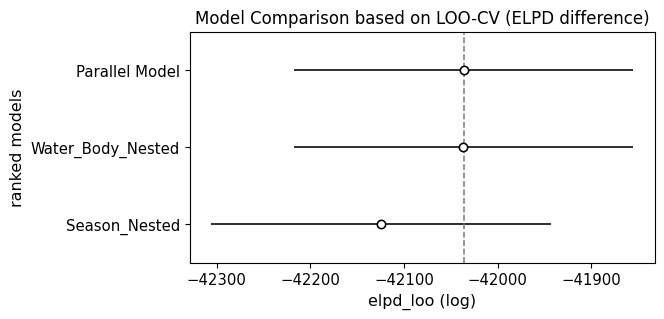

In [ ]:
# Example for trace_a (Model A: Site->WB->Global) - Repeat for others if needed!
models = [model_hier, model_a, model_b]

# Define the name used for the likelihood variable in ALL models
likelihood_var_name = 'likelihood'

# Initialize dictionaries to store results
loo_results_dict = {}
traces_with_loo = {} # To hold traces that successfully get LOO computed

print(f"\n--- Ensuring Log-Likelihood & Calculating LOO for all models ---")
print(f"Timestamp: {time.strftime('%Y-%m-%d %H:%M:%S %Z')}")
# Current time is Wednesday, May 7, 2025 at 8:32:27 PM PDT. Location: Lake Forest, California, United States

for m_idx, m in enumerate(models):
    model_name = m.name # Use the name attribute from your class
    print(f"\nProcessing {model_name} (Object index {m_idx})...")

    # Check if trace and model definition are available
    if m.trace is None:
        print(f"Skipping {model_name}: Trace is not loaded.")
        continue
    if m.model is None:
        print(f"Skipping {model_name}: Model definition object (m.model) not loaded/associated.")
        # Optional: Attempt to load/define model here if your class supports it
        # e.g., m.load_model(...)
        # If still None after attempt, then continue:
        # if m.model is None: continue
        continue # Cannot compute log-likelihood without the model structure

    log_like_ok = False # Flag to track if log-likelihood is ready

    # --- Step 1: Ensure Log-Likelihood ---
    log_likelihood_group = m.trace.get('log_likelihood') # Use .get for safer access

    # Check if the specific likelihood variable exists within the group
    if log_likelihood_group is not None and likelihood_var_name in log_likelihood_group:
        print(f"Log-likelihood for '{likelihood_var_name}' already present.")
        log_like_ok = True
        # Check if observed data is linked (often needed for LOO diagnostics/plots)
        if not (hasattr(m.trace, "observed_data") and likelihood_var_name in m.trace.observed_data):
             print(f"Warning: Log-likelihood found, but observed data link for '{likelihood_var_name}' seems missing in trace for {model_name}. LOO/PPC might have issues.")
             # You might need to manually add it here if it causes LOO errors later,
             # similar to the PPC linking step, requiring access to the original observed numpy array.
    else:
        # Compute log-likelihood if missing
        print(f"Log-likelihood missing for '{likelihood_var_name}'. Computing...")
        try:
            # Use the model stored in the object (must have observed=...)
            with m.model:
                # Call compute_log_likelihood WITHOUT var_name argument
                pm.compute_log_likelihood(m.trace)

            # Verify it was added using the expected name
            if hasattr(m.trace, 'log_likelihood') and likelihood_var_name in m.trace.log_likelihood:
                print(f"Log-likelihood computed and added for {model_name}.")
                log_like_ok = True
                # Verify observed data after computation (compute_log_likelihood might add it)
                if not (hasattr(m.trace, "observed_data") and likelihood_var_name in m.trace.observed_data):
                     print(f"Warning: Observed data link for '{likelihood_var_name}' still missing after compute_log_likelihood for {model_name}.")
            else:
                 # Check if it was added under a different name? Print available names.
                 computed_ll_vars = list(m.trace.log_likelihood.data_vars) if hasattr(m.trace, 'log_likelihood') else []
                 print(f"ERROR: Log-likelihood computation ran but variable '{likelihood_var_name}' not found in group for {model_name}.")
                 print(f"  Available log_likelihood variables: {computed_ll_vars}")

        except Exception as e:
            print(f"ERROR computing log-likelihood for {model_name}: {e}")
            print("  Ensure m.model exactly matches the original fit and includes the 'observed=...' argument in the likelihood definition.")

    # --- Step 2: Calculate LOO (if log-likelihood is ready) ---
    if log_like_ok:
        # Double-check observed data link one more time, as LOO might need it
        if not (hasattr(m.trace, "observed_data") and likelihood_var_name in m.trace.observed_data):
             print(f"Warning: Cannot calculate LOO for {model_name} because observed data link for '{likelihood_var_name}' is missing in trace.")
        else:
            try:
                print(f"Calculating LOO for {model_name}...")
                # az.loo uses the log_likelihood group already in m.trace
                # Specifying var_name is good practice if multiple likelihoods could exist
                current_loo = az.loo(m.trace, var_name=likelihood_var_name)
                loo_results_dict[model_name] = current_loo
                traces_with_loo[model_name] = m.trace # Store trace for az.compare
                print(f"LOO calculation complete for {model_name}.")
                # print(current_loo) # Optionally print individual LOO result

            except Exception as e:
                print(f"ERROR calculating LOO for {model_name}: {e}")
                # Check if error mentions observed data perhaps
    else:
        print(f"Skipping LOO calculation for {model_name} due to missing log-likelihood.")


print("\n--- Log-Likelihood check/computation & LOO Calculation Attempt Complete ---")


# --- Step 3: Compare Models ---
# This part assumes the loop above successfully populated traces_with_loo

if len(traces_with_loo) > 1:
    print("\n--- Model Comparison Results (LOO) ---")
    try:
        # Pass the dictionary of traces that successfully had LOO calculated
        # az.compare uses the LOO results stored within the trace objects' stats
        model_comparison = az.compare(traces_with_loo)
        print(model_comparison)

        print("\nPlotting LOO Comparison...")
        az.plot_compare(model_comparison, insample_dev=False) # Shows ELPD difference vs best model
        plt.title("Model Comparison based on LOO-CV (ELPD difference)")
        plt.show()
    except Exception as e:
        print(f"ERROR during model comparison: {e}")
else:
    print("\nNot enough models available with successful LOO results to compare.")
    if len(loo_results_dict) == 1:
         print("LOO result for the single successful model:")
         # Print the single result if needed
         single_model_name = list(loo_results_dict.keys())[0]
         print(f"\n--- LOO Summary for {single_model_name} ---")
         print(loo_results_dict[single_model_name])
